In [1]:
using Agents
using Graphs
#using Dynamics
using InteractiveDynamics
using GLMakie
using CairoMakie
using GraphMakie
using Karnak, Luxor, Colors
using NetworkLayout
using Plots
using StatsPlots

using Random
using Measures
using Compose, Cairo, Fontconfig
using LaTeXStrings
using StatsBase

using LinearAlgebra
using DataFrames
using Statistics
using RCall

using OpenStreetMapX

function suppress_R_warnings()
    R"options(warn=-1)"  # Set R's warning level to -1 to suppress all warnings
end


suppress_R_warnings (generic function with 1 method)

In [2]:
suppress_R_warnings()

RObject{VecSxp}
$warn
[1] 1



In [64]:
PLOT_COUNTER = 2;
Plot_Reset() = global PLOT_COUNTER = 0;
function Update_Plot_Counter()
    global PLOT_COUNTER += 1;
end

Update_Plot_Counter (generic function with 1 method)

In [65]:
x = rand(10);
y = rand(10);
r_cor = rcopy( R"cor.test($x,$y)" )

OrderedCollections.OrderedDict{Symbol, Any} with 9 entries:
  :statistic   => 1.40335
  :parameter   => 8
  :p_value     => 0.198116
  :estimate    => 0.444458
  :null_value  => 0.0
  :alternative => "two.sided"
  :method      => "Pearson's product-moment correlation"
  :data_name   => "`#JL`\$x and `#JL`\$y"
  :conf_int    => [-0.257121, 0.839232]

In [66]:
r_cor = rcopy( R"cor.test($x,$y)" )
r_cor[:p_value]

0.1981155829979847

### Create Graph Space

In [67]:
SEED = 123

# set up the dims of grid
const NN = 13
const GRID_DIM = (NN,NN)

# agent num = 75% of the node
TOTAL_AGENTS = round( Int, 0.75*prod(GRID_DIM) );

In [68]:
# Randomly deciding whether to add or remove edges to simulates the dynamic alteration of edges in the graph

function DiffEdgesGraphs(NN, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)
    GRID_DIM = (NN,NN)
    graph = Graphs.grid(GRID_DIM, periodic=false)
    
    for source_node in vertices(graph)

        # add edge
        if( rand() < THRESHOLD_RAND_EDGE_ADD )
            destination_node = rand( 1:nv(graph), 1)[1]

            if( destination_node != source_node )
                add_edge!(graph, source_node, destination_node)
            end
        end

        # remove edge
        if( rand() < THRESHOLD_RAND_EDGE_RM )
            neighbors = all_neighbors(graph, source_node)

            if( length(neighbors) > 0 )
                neighbor = rand( neighbors, 1)[1]
                rem_edge!(graph, source_node, neighbor)
            end
        end
    end
    return graph
end

DiffEdgesGraphs (generic function with 1 method)

### Model initial function

In [69]:
# Define Agent
@agent GraphSchellingAgent GraphAgent begin
    remain::Union{Number ,Bool}
    group::Int
end

In [70]:
rng1 = Random.Xoshiro(SEED)

Xoshiro(0xfefa8d41b8f5dca5, 0xf80cc98e147960c1, 0x20e2ccc17662fc1d, 0xea7a7dcb2e787c01)

In [71]:
# Initialize the model based on graph

function initialize(graph)
    global model_iteration = 0
    
    space = GraphSpace(graph)
    
    # The properties in model will now hold the min remain percentage = 0.5
    properties = Dict( :min_remain_percentage => 0.5 )
    
    # Set model as unremovable agent based model
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    agent_num = round( Int, 0.75*prod(nv(graph)) )
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:agent_num
        remain_temp = false
        group_temp = agent_ind < agent_num/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

initialize (generic function with 1 method)

### Agent step

This part is to define how we decide if the agent is going to move to next positoin based on the homogeneity and if they will be satisfy

In [72]:
# Get the position's nearby info include num of nearby position and homogeneity. 
# Can be use to get current agent & next positoin's nearby info

function PositionStatus(group, position, model)
    count_near = 0
    for pos in nearby_positions(position, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for id in nearby_ids( position, model , 1)
        agent = model[id]
        if agent.group == group
            count_neighbors_same_group += 1
        end
    end
    
    return [count_near, count_neighbors_same_group]
    
end

PositionStatus (generic function with 1 method)

In [73]:
# Caculate the urban level
# Reason: to prevent agent get into bad cycle because they move to a less connect hub(position that have less edges)

function NeighborhoodProb(pos_new, model)
    neighbor_num_vec = []
    
    for agent_tmp in allagents(model)
        nearby_num = length(collect(nearby_positions(agent_tmp.pos, model)))
        push!(neighbor_num_vec, nearby_num)
    end
    
    nearby_num = length(collect(nearby_positions(pos_new, model)))
    push!(neighbor_num_vec, nearby_num)
    
    unique_neighbor_num = unique(neighbor_num_vec)
    prob_remain = Dict()
    
    for k in unique_neighbor_num
        prob_remain[k] = 1 - (length(findall(k .< neighbor_num_vec))/length(neighbor_num_vec))
    end
         
    return prob_remain[length(collect(nearby_positions(pos_new, model)))]
end

NeighborhoodProb (generic function with 1 method)

In [74]:
# Decide if the next position would satisfy the agent
function NextPosition(agent, model)
    
    rand_pos = random_empty(model)
    count_near, count_neighbors_same_group = PositionStatus(agent.group, rand_pos, model)
    identify_stat = (count_neighbors_same_group / count_near) >= model.min_remain_percentage 

    # if the homogeneity doesn't satisfy. Reject moving.
    if(identify_stat != true)
        return -1
    end

    neigbor_prob = NeighborhoodProb(rand_pos, model)

    if( Int(identify_stat) * neigbor_prob > rand() ) 
        return rand_pos
    else
        return -1

    end
end

NextPosition (generic function with 1 method)

In [75]:
function agent_step!(agent, model)

    # Get current agent's nearby info
    count_near, count_neighbors_same_group = PositionStatus(agent.group, agent.pos, model)
    
    remain_current = (count_neighbors_same_group / count_near) >= model.min_remain_percentage
    if remain_current == true
        agent.remain = 1
        return 
    end
       
    # Get next posible place's nearby info
    newPosition = NextPosition(agent, model)
    # if newPosition is not -1, means the next position is better than current.
    if newPosition == -1
        agent.remain = 0
        return
    else
        agent.remain = 1
        move_agent!(agent , newPosition, model)
    end

end

agent_step! (generic function with 1 method)

### Entropy Calculation Functions

H(x)=−p(x)ln(p(x))

https://chat.openai.com/share/2f8b5ccf-beee-4bbc-a036-61b9b58245e1

In [76]:
# Get the % of agent stay in their pos
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain
    end
    return remain / nagents(model)
end

# Caculate graph entropy (Trace State) based on agent's group homogeneity
function GraphBaseEntropy(model)

    edge_total_num = 0
    agent_degree_distribution = Dict()

    for agent in allagents(model)
        edge_num = 0
        
        for near_agent in nearby_agents(agent,model, 1)
           if near_agent.group == agent.group
               edge_num += 1 
            end           
        end
        
        edge_total_num += edge_num
        
        if edge_num in keys(agent_degree_distribution)
            agent_degree_distribution[edge_num] += 1
        else
            agent_degree_distribution[edge_num] = 1
        end
    end
    
    # Get agent_degree_distribution prob
    for k in keys(agent_degree_distribution)
        agent_degree_distribution[k] /= edge_total_num
    end
    
    #println(agent_degree_distribution)
    H = 0
    
     for k in keys(agent_degree_distribution)
        H += (-1) * agent_degree_distribution[k] * log(agent_degree_distribution[k])
        
    end
    
    return H
end

GraphBaseEntropy (generic function with 1 method)

In [77]:
# Caculate graph entropy(Macro) based on node's connection
function GraphSpaceEntropy(model)
    G = model.space.graph

    node_total_num = nv(G)
    node_dregree_distrubution = Dict()
    
    for v in vertices(G)
        edge_num = length(collect(neighbors(G, v)))
        if edge_num in keys(node_dregree_distrubution)
            node_dregree_distrubution[edge_num] += 1
        else
            node_dregree_distrubution[edge_num] = 1
        end  
    end
    
    for k in keys(node_dregree_distrubution)
        node_dregree_distrubution[k] /= node_total_num
    end
    
    #println(node_dregree_distrubution)
    H = 0
    
    for k in keys(node_dregree_distrubution)
        H += (-1) * node_dregree_distrubution[k] * log(node_dregree_distrubution[k])       
    end

    return H

end

GraphSpaceEntropy (generic function with 1 method)

### Create model on graph space and get model data

In [78]:
# batch generate models based on input grpahs list

function ModelGenerator(graphsList)
    models = []
    for graph in graphsList
        model = initialize(graph)
        push!(models, model)
    end
    return models
end

ModelGenerator (generic function with 1 method)

In [79]:
# Record model's data after agent steps

function ModelDataRecord(init_graphs, step_num, loop_num)
    init_models = ModelGenerator(init_graphs)
    
    # Get the remain%, Entropy based on agent, and Entropy of the whole graph
    mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
    df = []
    remain = []
    graph_base_H =[]
    graph_space_H = []

    for (index, model) in pairs(init_models)

        _, model_df = run!(model, agent_step!, step_num; mdata)

        push!(df, model_df)
        push!(remain, model_df[:,:ModelRemainTrajectory])
        push!(graph_base_H, model_df[:,:GraphBaseEntropy])
        push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
    end
    
    LOOPS = 1:loop_num

    for i in LOOPS
        # initialize models on same graph
        init_models = ModelGenerator(init_graphs)
        for (index, model) in pairs(init_models)

            _, model_df = run!(model, agent_step!, step_num; mdata)
            graph_base_H[index] += model_df[:,:GraphBaseEntropy]
            remain[index] += model_df[:,:ModelRemainTrajectory]
        end
    end
    
    graph_base_H /= 1+length(LOOPS)
    remain /= 1+length(LOOPS)
    
    return remain, graph_base_H, graph_space_H
end

ModelDataRecord (generic function with 1 method)

In [80]:
# Shape: Square means satisfy, circle means not
const SIZE_SCALING_FACTOR = 1.5  # Increase size by 150%

function VertexShape(graph, model)    
    vertex_shape = [:circle for i in 1:nv(graph)]
    
    for agent in model.agents
        
        if( agent.remain==true)
            vertex_shape[ agent.pos ] = :square
        else 
            vertex_shape[ agent.pos ] = :circle
        end        
    end
    
    return vertex_shape
end

function VertexFillColors(graph, model)    
    vertex_colors = [ RGB(0, 0, 0) for i in 1:nv(graph) ]
    
    for agent in model.agents
        
        if( agent.group == 1 )
            vertex_colors[ agent.pos ] = RGB(1, 0.65, 0)
        else 
            vertex_colors[ agent.pos ] = RGB(0, 0, 1)
        end        
    end
    
    return vertex_colors
end

VertexFillColors (generic function with 1 method)

In [81]:
# takes in gs_H (entropy of the graph), remain, gb_H (entropy of the topology), 
function Simulation_Stats_OLD(cor_at_time, remain, gb_H, gs_H)
    
    result_str = "cor_at_time = $(cor_at_time)"

    HGs = [g[1] for g in gs_H]
    HGs = [round(h; digits=3) for h in HGs]
    HGstr = [L"H_g="*"$(h)" for h in HGs]
    HGstr = permutedims(HGstr)

    remain_at_time = [ remain[i][cor_at_time] for i in 1:length(remain) ]
    entropy_at_time = [gb_H[i][cor_at_time] for i in 1:length(gb_H)]

    r_spearman_graphentropy_remain = rcopy( R"cor.test($HGs, $remain_at_time, method=\"spearman\")" )
    r_spearman_graphentropy_remain_estimate = r_spearman_graphentropy_remain[:estimate]
    r_spearman_graphentropy_remain_p_value = r_spearman_graphentropy_remain[:p_value]
    result_str *= "\n\n correlation spearman (graph topology entropies with total remain) = $(r_spearman_graphentropy_remain_estimate) pval = $(r_spearman_graphentropy_remain_p_value)"

    r_HG_remain_t = rcopy( R"cor.test($HGs, $remain_at_time, method=\"pearson\")" )
    r_HG_remain_t_val = r_HG_remain_t[:estimate]
    r_HG_remain_t_pval = r_HG_remain_t[:p_value]
    result_str *= "\n\n correlation (graph topology entropies with total remain) = $(r_HG_remain_t_val) pval = $(r_HG_remain_t_pval)"
    
    r_cor_HG_S_t = rcopy( R"cor.test($HGs, $entropy_at_time, method=\"spearman\")" )
    r_cor_HG_S_t_val = r_cor_HG_S_t[:estimate]
    r_cor_HG_S_t_pval = r_cor_HG_S_t[:p_value]
    result_str *= "\n\n correlation spearman (graph topology entropies with agent entropy) = $(r_cor_HG_S_t_val) pval = $(r_cor_HG_S_t_pval)"

    r_cor_HG_S_t = rcopy( R"cor.test($HGs, $entropy_at_time)" )
    r_cor_HG_S_t_val = r_cor_HG_S_t[:estimate]
    r_cor_HG_S_t_pval = r_cor_HG_S_t[:p_value]
    result_str *= "\n\n correlation (HGs-graph entropies with entropt_at_time) = $(r_cor_HG_S_t_val) pval = $(r_cor_HG_S_t_pval)"
    
    r_spearman_remain_t_S_t = rcopy( R"cor.test($remain_at_time, $entropy_at_time, method=\"spearman\")" )
    r_spearman_remain_t_S_t_estimate = r_spearman_remain_t_S_t[:estimate]
    r_spearman_remain_t_S_t_pva = r_spearman_remain_t_S_t[:p_value]
    result_str *= "\n\n correlation spearman (remain_at_time with entropy_at_time) = $(r_spearman_remain_t_S_t_estimate) pval = $(r_spearman_remain_t_S_t_pva)"

    r_cor_remain_t_S_t = rcopy( R"cor.test($remain_at_time, $entropy_at_time)" )
    r_cor_HG_S_t_val = r_cor_remain_t_S_t[:estimate]
    r_cor_HG_S_t_pval = r_cor_remain_t_S_t[:p_value]
    result_str *= "\n\n correlation (remain_at_time with entropy_at_time) = $(r_cor_HG_S_t_val) pval = $(r_cor_HG_S_t_pval)"   
    
    return result_str
end

Simulation_Stats_OLD (generic function with 1 method)

In [82]:

function Simulation_Stats(cor_at_time, remain, gb_H, gs_H)
    
    result_str = "cor_at_time = $(cor_at_time)"

    HGs = [g[1] for g in gs_H]
    HGs = [round(h; digits=3) for h in HGs]
    HGstr = [L"H_g="*"$(h)" for h in HGs]
    HGstr = permutedims(HGstr)

    remain_at_time = [ remain[i][cor_at_time] for i in 1:length(remain) ]
    entropy_at_time = [gb_H[i][cor_at_time] for i in 1:length(gb_H)]

    metrics = Dict()

    # Spearman correlation between graph topology entropies and total remain
    r_spearman_graphentropy_remain = rcopy( R"cor.test($HGs, $remain_at_time, method='spearman')" )
    metrics["r_spearman_graphentropy_remain"] = (r_spearman_graphentropy_remain[:estimate], r_spearman_graphentropy_remain[:p_value])
    result_str *= "\n\n correlation spearman (graph topology entropies with total remain) = $(metrics["r_spearman_graphentropy_remain"][1]) pval = $(metrics["r_spearman_graphentropy_remain"][2])"

    # Pearson correlation between graph topology entropies and total remain
    r_HG_remain_t = rcopy( R"cor.test($HGs, $remain_at_time, method='pearson')" )
    metrics["r_HG_remain_t"] = (r_HG_remain_t[:estimate], r_HG_remain_t[:p_value])
    result_str *= "\n\n correlation (graph topology entropies with total remain) = $(metrics["r_HG_remain_t"][1]) pval = $(metrics["r_HG_remain_t"][2])"
    
    # Spearman correlation between graph topology entropies and agent entropy
    r_cor_HG_S_t = rcopy( R"cor.test($HGs, $entropy_at_time, method='spearman')" )
    metrics["r_cor_HG_S_t_spearman"] = (r_cor_HG_S_t[:estimate], r_cor_HG_S_t[:p_value])
    result_str *= "\n\n correlation spearman (graph topology entropies with agent entropy) = $(metrics["r_cor_HG_S_t_spearman"][1]) pval = $(metrics["r_cor_HG_S_t_spearman"][2])"

    # Pearson correlation between graph topology entropies and agent entropy
    r_cor_HG_S_t = rcopy( R"cor.test($HGs, $entropy_at_time)" )
    metrics["r_cor_HG_S_t_pearson"] = (r_cor_HG_S_t[:estimate], r_cor_HG_S_t[:p_value])
    result_str *= "\n\n correlation (HGs-graph entropies with entropy_at_time) = $(metrics["r_cor_HG_S_t_pearson"][1]) pval = $(metrics["r_cor_HG_S_t_pearson"][2])"
    
    # Spearman correlation between remain_at_time and entropy_at_time
    r_spearman_remain_t_S_t = rcopy( R"cor.test($remain_at_time, $entropy_at_time, method='spearman')" )
    metrics["r_spearman_remain_t_S_t"] = (r_spearman_remain_t_S_t[:estimate], r_spearman_remain_t_S_t[:p_value])
    result_str *= "\n\n correlation spearman (remain_at_time with entropy_at_time) = $(metrics["r_spearman_remain_t_S_t"][1]) pval = $(metrics["r_spearman_remain_t_S_t"][2])"

    # Pearson correlation between remain_at_time and entropy_at_time
    r_cor_remain_t_S_t = rcopy( R"cor.test($remain_at_time, $entropy_at_time)" )
    metrics["r_cor_remain_t_S_t"] = (r_cor_remain_t_S_t[:estimate], r_cor_remain_t_S_t[:p_value])
    result_str *= "\n\n correlation (remain_at_time with entropy_at_time) = $(metrics["r_cor_remain_t_S_t"][1]) pval = $(metrics["r_cor_remain_t_S_t"][2])"   
    
    return [result_str, metrics]
end

function collect_simulation_stats(max_cor_at_time, remain, gb_H, gs_H)
    # Initialize an array to hold the dictionaries returned by each Simulation_Stats call
    stats_array = []

    # Iterate over the range from 1 to max_cor_at_time
    for cor_at_time in 1:max_cor_at_time
        # Call Simulation_Stats and ignore the string result using `_`
        _, stats_dict = Simulation_Stats(cor_at_time, remain, gb_H, gs_H)

        # Append the dictionary to the stats_array
        push!(stats_array, stats_dict)
    end

    return stats_array
end


function prepare_significant_estimates_data(remain, gb_H, gs_H, cor_type="r_cor_remain_t_S_t")
    resulting_stats = collect_simulation_stats(size(remain[1])[1], remain, gb_H, gs_H)

    # Extract estimates and their corresponding p-values
    estimates = [resulting_stats[i][cor_type][1] for i in 1:length(resulting_stats)]
    pvals = [resulting_stats[i][cor_type][2] for i in 1:length(resulting_stats)]

    # Initialize filtered_estimates with NaN values
    filtered_estimates = fill(NaN, length(estimates))

    # Filter estimates based on p-values
    for (i, (est, pval)) in enumerate(zip(estimates, pvals))
        if !ismissing(pval) && pval <= 0.05
            filtered_estimates[i] = est
        end
    end

    # Prepare x-values
    x_values = 1:length(estimates)

    return x_values, filtered_estimates
end


prepare_significant_estimates_data (generic function with 2 methods)

## Download OpenStreetMap Network

In [83]:
ucf_map_data = get_map_data("./maps/ucfmap.osm");
tokyo_map_data = get_map_data("./maps/tokyo_map.osm");
tampa_map_data = get_map_data("./maps/tampa_map.osm")
miami_map_data = get_map_data("./maps/miami_map.osm")
jackson_map_data = get_map_data("./maps/jacksonville_map.osm")
beijing_map_data = get_map_data("./maps/beijing_map.osm")
washington_map_data = get_map_data("./maps/washington_map.osm")

Austin_map_data = get_map_data("./maps/Austin.osm");
Boston_map_data = get_map_data("./maps/Boston.osm");
Chicago_map_data = get_map_data("./maps/Chicago.osm");
Miami_map_data = get_map_data("./maps/Miami.osm");
Orlando_map_data = get_map_data("./maps/Orlando.osm");
SanFrancisco_map_data = get_map_data("./maps/SanFrancisco.osm");
Seattle_map_data = get_map_data("./maps/Seattle.osm");


ucf_graph = SimpleGraph(ucf_map_data.g)
tokyo_graph = SimpleGraph(tokyo_map_data.g)
washington_graph = SimpleGraph(washington_map_data.g)
beijing_graph = SimpleGraph(beijing_map_data.g)
jackson_graph = SimpleGraph(jackson_map_data.g)
miami_graph = SimpleGraph(miami_map_data.g)
tampa_graph = SimpleGraph(tampa_map_data.g)

Austin_graph = SimpleGraph(Austin_map_data.g)
Boston_graph = SimpleGraph(Boston_map_data.g)
Chicago_graph = SimpleGraph(Chicago_map_data.g)
Miami_graph = SimpleGraph(Miami_map_data.g)
Orlando_graph = SimpleGraph(Orlando_map_data.g)
SanFrancisco_graph = SimpleGraph(SanFrancisco_map_data.g)
Seattle_graph = SimpleGraph(Seattle_map_data.g)

[ Info: Read map data from cache ./maps/ucfmap.osm.cache
[ Info: Read map data from cache ./maps/tokyo_map.osm.cache
[ Info: Read map data from cache ./maps/tampa_map.osm.cache
[ Info: Read map data from cache ./maps/miami_map.osm.cache
[ Info: Read map data from cache ./maps/jacksonville_map.osm.cache
[ Info: Read map data from cache ./maps/beijing_map.osm.cache
[ Info: Read map data from cache ./maps/washington_map.osm.cache
[ Info: Read map data from cache ./maps/Austin.osm.cache
[ Info: Read map data from cache ./maps/Boston.osm.cache
[ Info: Read map data from cache ./maps/Chicago.osm.cache
[ Info: Read map data from cache ./maps/Miami.osm.cache
[ Info: Read map data from cache ./maps/Orlando.osm.cache
[ Info: Read map data from cache ./maps/SanFrancisco.osm.cache
[ Info: Read map data from cache ./maps/Seattle.osm.cache


{523, 625} undirected simple Int64 graph

### Visualize Graph after Steps

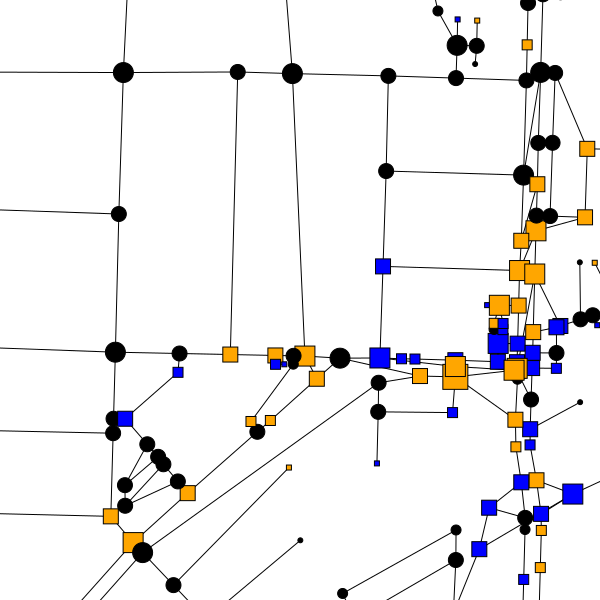

In [84]:
keys_array = []
enu1_array = []
enu2_array = []
nodeID_array = []
# Extract key and first two ENU values from the dataset
for key in miami_map_data.n
    push!(keys_array, key)
    push!(enu1_array, miami_map_data.nodes[key].east)
    push!(enu2_array, miami_map_data.nodes[key].north)
    push!(nodeID_array, miami_map_data.v[key])
end

# Create a DataFrame from the extracted data
df_miami = DataFrame(Key = keys_array,GraphID = nodeID_array, ENU1 = enu1_array, ENU2 = enu2_array);

miami_positions = @. Karnak.Point(df_miami.ENU1,df_miami.ENU2);

scale = 2.5

@pdf begin
    background("white")
    drawgraph(miami_graph, 
    layout = miami_positions,
    vertexshapes = VertexShape(miami_graph, model),
    vertexshapesizes = [Graphs.outdegree(miami_graph, v) * scale for v in Graphs.vertices(miami_graph)],
    vertexfillcolors = VertexFillColors(miami_graph, model) )
    #Karnak.text( "Miami Map Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
    end 1000 1000 "./plots/Fig$(PLOT_COUNTER)_miamiZoomedIn.pdf"
#Update_Plot_Counter()

@drawsvg begin
    background("white")
    drawgraph(miami_graph, 
    layout = miami_positions,
    vertexshapes = VertexShape(miami_graph, model),
    vertexshapesizes = [Graphs.outdegree(miami_graph, v) * scale for v in Graphs.vertices(miami_graph)],
    vertexfillcolors = VertexFillColors(miami_graph, model) )
    #Karnak.text( "Miami Map Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
end

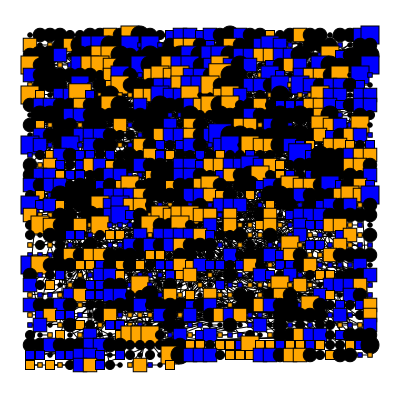

In [85]:
model = initialize(miami_graph)

step_num = 30
Agents.step!(model, agent_step!, step_num)

scale = 2.25

@pdf begin
    background("white")
    drawgraph(miami_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(miami_graph, model),
        vertexshapesizes = [Graphs.outdegree(miami_graph, v) * scale for v in Graphs.vertices(miami_graph)],
        vertexfillcolors = VertexFillColors(miami_graph, model) )
    #Karnak.text( "Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
    end 1000 1000 "./plots/Fig$(PLOT_COUNTER)_miami30.pdf"
Update_Plot_Counter()

pic = @drawsvg begin
    background("white")
    drawgraph(miami_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(miami_graph, model),
        vertexshapesizes = [Graphs.outdegree(miami_graph, v) * scale  for v in Graphs.vertices(miami_graph)],
        vertexfillcolors = VertexFillColors(miami_graph, model) )
    #Karnak.text( "Graph Agent - Initial - Step:30", boxtopcenter() + (0, 10), halign=:center)
end 400 400
#miami 30 steps with scalling agents on connectivity and square is satisfied agents and circle otherwise
#subset of miami graph is (1170 number of nodes, 1451 number of edges) 75 of agents

In [120]:
function Plot_Colors(num)
    return collect( cgrad(:viridis, num, categorical=true) )'
end

Plot_Colors (generic function with 1 method)

# RESULTS

## exploring remain ratio

In [132]:

function initialize_stay(remain_percentage)
    global model_iteration = 0
    
    graph = DiffEdgesGraphs(13, 0.0, 0.0)
    space = GraphSpace(graph)
    
    # The properties in model will now hold the min remain percentage
    properties = Dict( :min_remain_percentage => remain_percentage )
    
    # Set model as unremovable agent based model
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    agent_num = round( Int, 0.75*prod(nv(graph)) )
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:agent_num
        remain_temp = false
        group_temp = agent_ind < agent_num/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

stay_graph_models = []

push!(stay_graph_models, initialize_stay(0.1))
push!(stay_graph_models, initialize_stay(0.2))
push!(stay_graph_models, initialize_stay(0.3))
push!(stay_graph_models, initialize_stay(0.4))
push!(stay_graph_models, initialize_stay(0.5))
push!(stay_graph_models, initialize_stay(0.6))
push!(stay_graph_models, initialize_stay(0.7))
push!(stay_graph_models, initialize_stay(0.8));

mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
df = []
remain = []
graph_base_H =[]
graph_space_H = []
step_num = 30

for (index, model) in pairs(stay_graph_models)

    _, model_df = run!(model, agent_step!, step_num; mdata)

    push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:100

for i in LOOPS
    # initialize models on same graph
    stay_graph_models = []

    push!(stay_graph_models, initialize_stay(0.1))
    push!(stay_graph_models, initialize_stay(0.2))
    push!(stay_graph_models, initialize_stay(0.3))
    push!(stay_graph_models, initialize_stay(0.4))
    push!(stay_graph_models, initialize_stay(0.5))
    push!(stay_graph_models, initialize_stay(0.6))
    push!(stay_graph_models, initialize_stay(0.7))
    push!(stay_graph_models, initialize_stay(0.8))
    for (index, model) in pairs(stay_graph_models)

        _, model_df = run!(model, agent_step!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS)
remain /= 1+length(LOOPS);

HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
HGstr = [L"H_{0.2}="*"$(HGs[1])",L"H_{0.3}="*"$(HGs[1])", L"H_{0.4}="*"$(HGs[2])",L"H_{0.5}="*"$(HGs[3])",L"H_{0.6}="*"$(HGs[4])",L"H_{0.7}="*"$(HGs[5])"]
HGstr = permutedims(HGstr)

resulting_stats = collect_simulation_stats(10, remain,graph_base_H, graph_space_H);
resulting_stats[7];

In [133]:
[ remain[i][cor_at_time] for i in 1:length(remain) ]

8-element Vector{Float64}:
 1.0
 1.0
 0.9829266391206056
 0.9681141342480698
 0.9656193965853274
 0.7895065097060885
 0.7225383955718402
 0.44359554065642787

In [134]:
x_values, significant_estimates = prepare_significant_estimates_data(remain, 
    graph_base_H, graph_base_H, "r_spearman_remain_t_S_t")

(1:31, [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN])

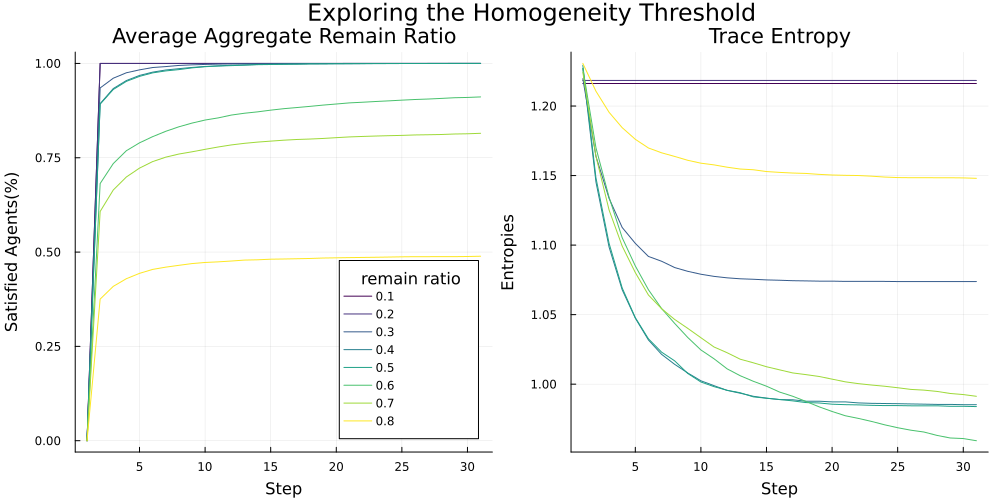

In [140]:
colors = Plot_Colors(length(remain))
log_remain = [log.(max.(d, 1e-10)) for d in remain]

p1 = Plots.plot(remain, xlabel = "Step", ylabel = "Satisfied Agents(%)",legend=true, labels=collect(0.1:0.1:0.8)', 
    legendtitle="remain ratio", color=colors, 
    title="Average Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

# p2 = Plots.plot(log_remain, xlabel = "Step", ylabel = "Log Satisfied Agents(%)",legend=true, labels=collect(0.1:0.1:0.8)', 
#     legendtitle="remain ratio", color=colors, 
#     title="Average Log Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

p2 = Plots.plot(graph_base_H, xlabel = "Step",ylabel = "Entropies", legend=false, color=colors, 
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm, bottom_margin = 3Measures.mm )

# p3 = Plots.scatter(x_values, significant_estimates, label="Significant Estimates",
#         xlabel="Step", ylabel="Estimate", title="Significant Correlation Estimates",
#         legend=:topright)

p = Plots.plot(p1,p2, plot_title="Exploring the Homogeneity Threshold", size=(1000,500), layout=(1,2) )

savefig("./plots/Fig$(PLOT_COUNTER)_remainProbExplore.pdf")
Update_Plot_Counter()
display(p)

## Exploring altered Grids

In [141]:
simple_graphs = []
push!(simple_graphs, DiffEdgesGraphs(13, 0.0, 0.0))
push!(simple_graphs, DiffEdgesGraphs(13, 0.0, 0.40))
push!(simple_graphs, DiffEdgesGraphs(13, 0.0, 0.90))
push!(simple_graphs, DiffEdgesGraphs(13, 0.40, 0.0))
push!(simple_graphs, DiffEdgesGraphs(13, 0.90, 0.0))
push!(simple_graphs, DiffEdgesGraphs(13, 0.20, 0.20))
push!(simple_graphs, DiffEdgesGraphs(13, 0.70, 0.70)) 
println(length(simple_graphs))

# record data for simple graph with 30 agent steps and 100 loop 
remain, gb_H, gs_H = ModelDataRecord(simple_graphs, 30, 100);

HGs = [g[1] for g in gs_H];

HGstr = [L"H_g="*"$(round(h,digits=3))" for h in HGs]
HGstr = permutedims(HGstr)

println( Simulation_Stats_OLD(5, remain, gb_H, gs_H) )

r,m = Simulation_Stats(5, remain, gb_H, gs_H)
resulting_stats = collect_simulation_stats(10, remain, gb_H, gs_H);
x_values, significant_estimates = prepare_significant_estimates_data(remain, gb_H, gs_H, "r_cor_remain_t_S_t")

7
cor_at_time = 5

 correlation spearman (graph topology entropies with total remain) = -0.6847124716486247 pval = 0.0896664531910684

 correlation (graph topology entropies with total remain) = -0.40185277156308064 pval = 0.37151560356770785

 correlation spearman (graph topology entropies with agent entropy) = -0.27028123880866767 pval = 0.5577307488053698

 correlation (HGs-graph entropies with entropt_at_time) = 0.10590750141688617 pval = 0.8212124642464385

 correlation spearman (remain_at_time with entropy_at_time) = 0.7857142857142855 pval = 0.04801587301587302

 correlation (remain_at_time with entropy_at_time) = 0.835196660099208 pval = 0.01933783512324994


(1:31, [NaN, 0.9322075468830633, 0.8951910898603268, 0.859379338437136, 0.835196660099208, 0.8074290611096103, 0.7981494218468019, 0.7955055141383662, 0.7914515574438536, 0.7861754075784282  …  0.7570349943157313, NaN, NaN, NaN, 0.7563968393457248, NaN, NaN, NaN, NaN, 0.7578295644664178])

In [142]:
resulting_stats[5]

Dict{Any, Any} with 6 entries:
  "r_cor_HG_S_t_pearson"           => (0.105908, 0.821212)
  "r_cor_HG_S_t_spearman"          => (-0.270281, 0.557731)
  "r_cor_remain_t_S_t"             => (0.835197, 0.0193378)
  "r_spearman_remain_t_S_t"        => (0.785714, 0.0480159)
  "r_spearman_graphentropy_remain" => (-0.684712, 0.0896665)
  "r_HG_remain_t"                  => (-0.401853, 0.371516)

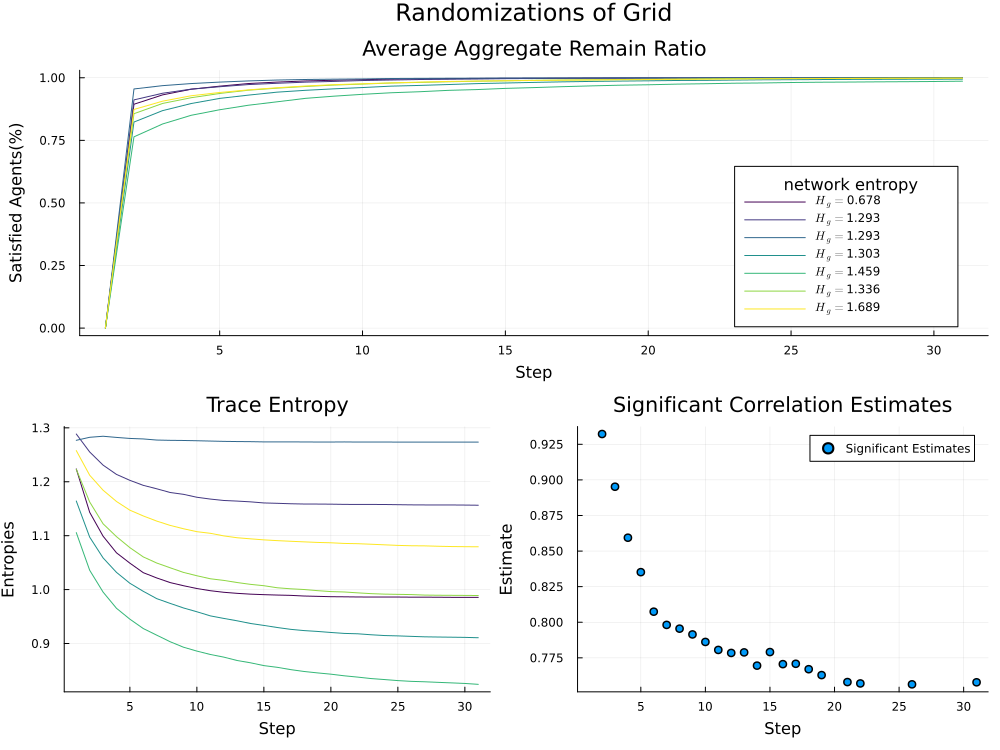

In [144]:
colors = Plot_Colors(length(remain))
#log_remain = [log.(max.(d, 1e-10)) for d in remain]

p1 = Plots.plot(remain, xlabel = "Step",ylabel = "Satisfied Agents(%)",legend=true,labels = HGstr, 
    legendtitle="network entropy", color=colors,
    title="Average Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

p2 = Plots.plot(gb_H, xlabel = "Step",ylabel = "Entropies", legend=false, color=colors,
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm, bottom_margin = 3Measures.mm )

p3 = Plots.scatter(x_values, significant_estimates, label="Significant Estimates",
        xlabel="Step", ylabel="Estimate", title="Significant Correlation Estimates",
        legend=:topright)

p = Plots.plot(p1,p2,p3, plot_title="Randomizations of Grid", size=(1000,750), layout=@layout([A{0.5h}; [B C]]) )

savefig("./plots/Fig$(PLOT_COUNTER)_entropySyntheticH.pdf")
Update_Plot_Counter()
display(p)

## Create different network types of graphs

Barabasi Albert
Scale Free
Random

In [31]:
num_nodes = prod(GRID_DIM)
num_edges = ne(simple_graphs[1])
num_hub = 1
barabasi_albert_residential_graph_1 = Graphs.barabasi_albert(num_nodes, 5)
barabasi_albert_residential_graph_2 = Graphs.barabasi_albert(num_nodes, 3)

scale_free_residential_graph_1 = Graphs.static_scale_free(num_nodes,num_edges,2)
scale_free_residential_graph_2 = Graphs.static_scale_free(num_nodes,num_edges,3)

random_residential_graph = Graphs.random_regular_graph(num_nodes, 4)

newman_watts_strogatz_residential_graph = Graphs.newman_watts_strogatz(num_nodes, 4, 0.3)

diff_network_graphs = []

push!(diff_network_graphs, barabasi_albert_residential_graph_1)
push!(diff_network_graphs, barabasi_albert_residential_graph_2)
push!(diff_network_graphs, scale_free_residential_graph_1)
push!(diff_network_graphs, scale_free_residential_graph_2)
push!(diff_network_graphs, newman_watts_strogatz_residential_graph)
push!(diff_network_graphs, DiffEdgesGraphs(13, 0.0, 0.0))

# record data for simple graph with 30 agent steps and 100 loop 
network_remain, network_gb_H, network_gs_H = ModelDataRecord(diff_network_graphs, 30, 100);

In [32]:
HGs = [g[1] for g in network_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{BA1}="*"$(HGs[1])", L"H_{BA2}="*"$(HGs[2])",L"H_{SF1}="*"$(HGs[3])", L"H_{SF2}="*"$(HGs[4])",L"H_{NWS}="*"$(HGs[5])", L"H_{Grid}="*"$(HGs[6])"]
HGstr = permutedims(HGstr)

x_values, significant_estimates = prepare_significant_estimates_data(network_remain, network_gb_H, 
    network_gs_H, "r_cor_remain_t_S_t" )

(1:31, [NaN, 0.9108717332346122, 0.8241412055761711, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN])

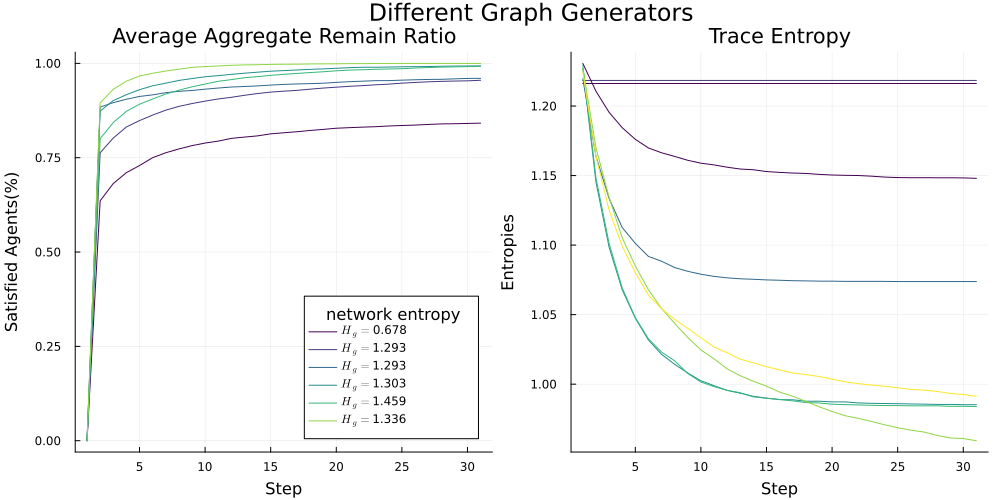

In [145]:
colors = Plot_Colors(length(network_remain))

p1 = Plots.plot(network_remain, xlabel = "Step",ylabel = "Satisfied Agents(%)",legend=true, labels=HGstr, 
    legendtitle="network entropy", color=colors,
    title="Average Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

p2 = Plots.plot(graph_base_H, xlabel = "Step",ylabel = "Entropies", legend=false, color=colors,
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm, bottom_margin = 3Measures.mm )

p = Plots.plot(p1,p2, plot_title="Different Graph Generators", size=(1000,500), layout=(1,2)  )

savefig("./plots/Fig$(PLOT_COUNTER)_graphTypes.pdf")
Update_Plot_Counter()
display(p)

In [146]:
capitial_map_graphs = []

push!(capitial_map_graphs, DiffEdgesGraphs(34, 0.0, 0.0))
push!(capitial_map_graphs, beijing_graph)
push!(capitial_map_graphs, tokyo_graph)
push!(capitial_map_graphs, washington_graph)

# record data for capital openstreet map graph with 30 agent steps and 100 loop 
capital_map_remain, capital_map_gb_H, capital_map_gs_H = ModelDataRecord(capitial_map_graphs, 30, 100);

resulting_stats = collect_simulation_stats(6, capital_map_remain, capital_map_gb_H, capital_map_gs_H);
resulting_stats[5]

x_values, significant_estimates = prepare_significant_estimates_data(capital_map_remain, 
    capital_map_gb_H, capital_map_gs_H, "r_cor_HG_S_t_pearson")

(1:31, [0.9886920581843744, 0.9898275639584531, 0.9895015035016647, 0.9891446539111625, 0.9890655917700681, 0.9887062477353664, 0.9879371760203494, 0.9874611145190054, 0.9870604534912113, 0.9867556764655873  …  0.9832667839359723, 0.9831231178040175, 0.9829825944273459, 0.982864501516907, 0.9827616539776504, 0.9827158665380854, 0.982652198128897, 0.9825869854466052, 0.9825728200160856, 0.982474935272023])

In [147]:
HGs = [g[1] for g in capital_map_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{beijing}="*"$(HGs[2])",L"H_{tokyo}="*"$(HGs[3])",L"H_{washington}="*"$(HGs[4])"]
HGstr = permutedims(HGstr)

1×4 Matrix{String}:
 "\$H_{Baseline}=\$0.371"  …  "\$H_{washington}=\$1.427"

In [148]:
cor_at_time = 5

5

In [149]:
remain_at_time = [capital_map_remain[i][cor_at_time] for i in 1:length(capital_map_remain)]

spearman_score_remain = corspearman(HGs, remain_at_time)
spearman_score_remain = round(spearman_score_remain; digits=3)

-0.4

In [150]:
entropy_at_time = [capital_map_gb_H[i][cor_at_time] for i in 1:length(capital_map_gb_H)]
spearman_score_entropy = corspearman(HGs, entropy_at_time)
spearman_score_entropy = round(spearman_score_entropy; digits=3)

0.8

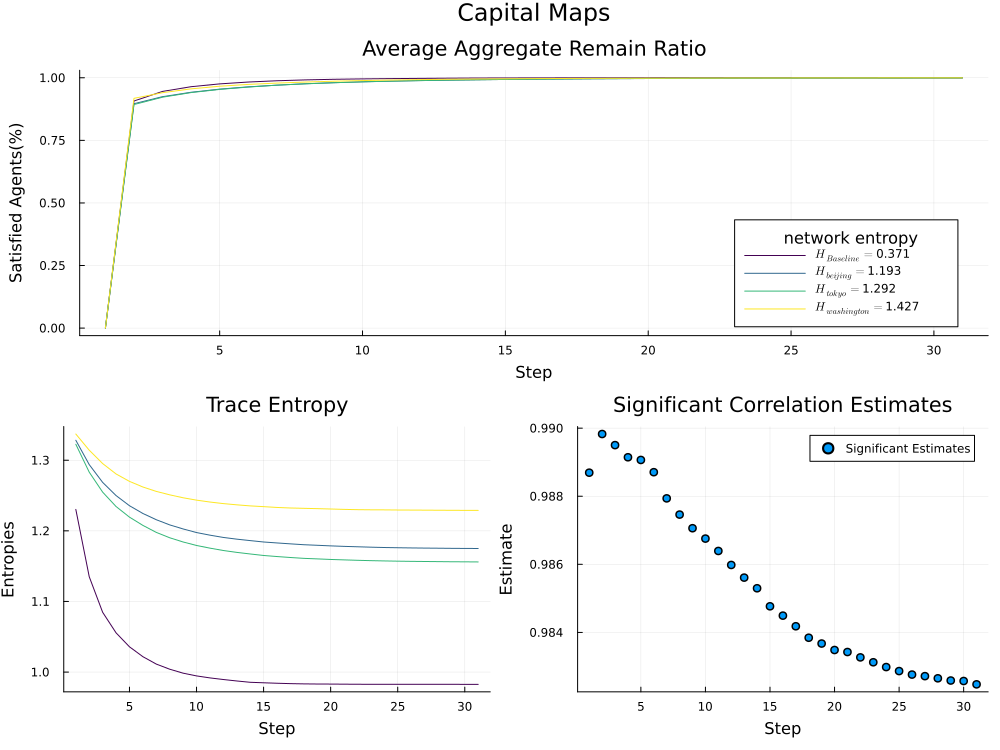

In [153]:
colors = Plot_Colors(length(capital_map_remain))

p1 = Plots.plot(capital_map_remain, xlabel = "Step",ylabel = "Satisfied Agents(%)",legend=true,labels = HGstr, 
    legendtitle="network entropy", color=colors,
    title="Average Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

p2 = Plots.plot(capital_map_gb_H, xlabel = "Step",ylabel = "Entropies", legend=false, color=colors,
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm, bottom_margin = 3Measures.mm )

p3 = Plots.scatter(x_values, significant_estimates, label="Significant Estimates",
        xlabel="Step", ylabel="Estimate", title="Significant Correlation Estimates",
        legend=:topright)

p = Plots.plot(p1,p2,p3, plot_title="Capital Maps", size=(1000,750), layout=@layout([A{0.5h}; [B C]]) )

savefig("./plots/Fig$(PLOT_COUNTER)_remainCapitals.pdf")
Update_Plot_Counter()
display(p)

In [152]:
city_map_graphs = []

push!(city_map_graphs, DiffEdgesGraphs(34, 0.0, 0.0))
push!(city_map_graphs, jackson_graph)
push!(city_map_graphs, miami_graph)
push!(city_map_graphs, tampa_graph)

4-element Vector{Any}:
 {1156, 2244} undirected simple Int64 graph
 {1497, 1943} undirected simple Int64 graph
 {1170, 1451} undirected simple Int64 graph
 {1411, 1718} undirected simple Int64 graph

In [41]:
# record data for cities openstreet map graph with 30 agent steps and 100 loop 
city_map_remain, city_map_gb_H, city_map_gs_H = ModelDataRecord(city_map_graphs, 30, 100);

In [42]:
HGs = [g[1] for g in city_map_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{Jackson}="*"$(HGs[2])",L"H_{Miami}="*"$(HGs[3])",L"H_{Tampa}="*"$(HGs[4])"]
HGstr = permutedims(HGstr)

1×4 Matrix{String}:
 "\$H_{Baseline}=\$0.371"  "\$H_{Jackson}=\$1.268"  …  "\$H_{Tampa}=\$1.274"

In [43]:
cor_at_time = 5

5

In [44]:
remain_at_time = [city_map_remain[i][cor_at_time] for i in 1:length(city_map_remain)]

spearman_score_remain = corspearman(HGs, remain_at_time)
spearman_score_remain = round(spearman_score_remain; digits=3)

-0.4

In [45]:
entropy_at_time = [city_map_gb_H[i][cor_at_time] for i in 1:length(city_map_gb_H)]
spearman_score_entropy = corspearman(HGs, entropy_at_time)
spearman_score_entropy = round(spearman_score_entropy; digits=3)

0.8

In [46]:
corspearman(remain_at_time, entropy_at_time)

-0.2

In [47]:
cor(remain_at_time, entropy_at_time)

-0.887957692752314

In [48]:
x_values, significant_estimates = prepare_significant_estimates_data(city_map_remain, 
    city_map_gb_H, city_map_gs_H, "r_cor_HG_S_t_pearson")

(1:31, [0.999441695444772, 0.9989661239756635, 0.998177946908956, 0.9978145911259199, 0.9973348213101842, 0.9968061454287881, 0.9963154149401996, 0.9960304456695843, 0.9956700325712368, 0.9952080530502404  …  0.9931812754442316, 0.9931259909646029, 0.9930043705694399, 0.9928952158558272, 0.9928523838065082, 0.9928092131203196, 0.9927353324588126, 0.9927048317499274, 0.992686035747776, 0.9926758117760835])

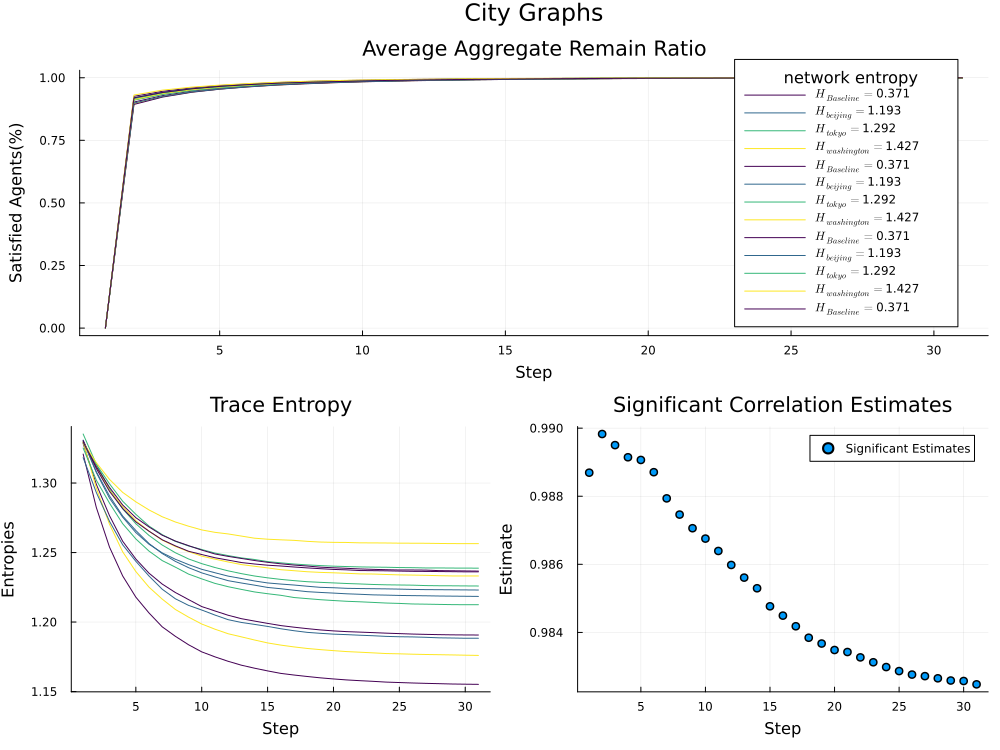

In [154]:
colors = Plot_Colors(length(capital_map_remain))

p1 = Plots.plot(city_map_remain, xlabel = "Step",ylabel = "Satisfied Agents(%)",legend=true,labels = HGstr, 
    legendtitle="network entropy", color=colors,
    title="Average Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

p2 = Plots.plot(city_map_gb_H, xlabel = "Step",ylabel = "Entropies", legend=false, color=colors,
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm, bottom_margin = 3Measures.mm )

p3 = Plots.scatter(x_values, significant_estimates, label="Significant Estimates",
        xlabel="Step", ylabel="Estimate", title="Significant Correlation Estimates",
        legend=:topright)

p = Plots.plot(p1,p2,p3, plot_title="City Graphs", size=(1000,750), layout=@layout([A{0.5h}; [B C]]) )

savefig("./plots/Fig$(PLOT_COUNTER)_remainCitiesFL.pdf")
Update_Plot_Counter()
display(p)

In [50]:
# p9 = Plots.plot(city_map_remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, 
#     title="Cities Map Remain Agents", size=(900, 700), left_margin = 2Measures.mm )
# savefig("./plots/Fig9remainCities.pdf")
# display(p9)

In [51]:
# p10 = Plots.plot(city_map_gb_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,
#     title="Cities Map Model Entropy", size=(900, 700),left_margin = 2Measures.mm )
# savefig("./plots/Fig10entropyCapitals.pdf")
# display(p10)

In [52]:
city_map_graphs = []

#push!(city_map_graphs, DiffEdgesGraphs(34, 0.0, 0.0))
push!(city_map_graphs, jackson_graph)
push!(city_map_graphs, miami_graph)
push!(city_map_graphs, tampa_graph)
push!(city_map_graphs, beijing_graph)
push!(city_map_graphs, tokyo_graph)
push!(city_map_graphs, washington_graph)

push!(city_map_graphs, Austin_graph)
push!(city_map_graphs, Boston_graph)
push!(city_map_graphs, Chicago_graph)
push!(city_map_graphs, Miami_graph)
push!(city_map_graphs, Orlando_graph)
push!(city_map_graphs, SanFrancisco_graph)
push!(city_map_graphs, Seattle_graph)

city_map_remain, city_map_gb_H, city_map_gs_H = ModelDataRecord(city_map_graphs, 30, 100);

HGs = [g[1] for g in city_map_gs_H]
HGs = [round(h; digits=3) for h in HGs]

HGstr = [L"H_{Jackson}="*"$(HGs[1])",L"H_{Miami}="*"$(HGs[2])",L"H_{Tampa}="*"$(HGs[3])",
             L"H_{Beijing}="*"$(HGs[4])",L"H_{Tokyo}="*"$(HGs[5])",L"H_{Washington}="*"$(HGs[6])",
             L"H_{Austin_graph}="*"$(HGs[7])", L"H_{Boston_graph}="*"$(HGs[8])", 
            L"H_{Chicago_graph}="*"$(HGs[9])",
            L"H_{Miami_graph}="*"$(HGs[10])", L"H_{Orlando_graph}="*"$(HGs[11])", 
            L"H_{SanFrancisco_graph}="*"$(HGs[12])",L"H_{Seattle_graph}="*"$(HGs[13])"]

# HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{Jackson}="*"$(HGs[2])",L"H_{Miami}="*"$(HGs[3])",L"H_{Tampa}="*"$(HGs[4])",
#              L"H_{Beijing}="*"$(HGs[5])",L"H_{Tokyo}="*"$(HGs[6])",L"H_{Washington}="*"$(HGs[7])"]
HGstr = permutedims(HGstr);

In [53]:
cor_at_time = 5

5

In [54]:
remain_at_time = [city_map_remain[i][cor_at_time] for i in 1:length(city_map_remain)]

spearman_score_remain = corspearman(HGs, remain_at_time)
spearman_score_remain = round(spearman_score_remain; digits=3)

0.803

In [55]:
r_cor = rcopy( R"cor.test($HGs, $remain_at_time, method=\"spearman\")" )

OrderedCollections.OrderedDict{Symbol, Any} with 8 entries:
  :statistic   => 71.5981
  :parameter   => nothing
  :p_value     => 0.000941544
  :estimate    => 0.803302
  :null_value  => 0.0
  :alternative => "two.sided"
  :method      => "Spearman's rank correlation rho"
  :data_name   => "`#JL`\$HGs and `#JL`\$remain_at_time"

In [56]:
r_cor = rcopy( R"cor.test($HGs, $remain_at_time)" )

OrderedCollections.OrderedDict{Symbol, Any} with 9 entries:
  :statistic   => 4.74737
  :parameter   => 11
  :p_value     => 0.000602234
  :estimate    => 0.819762
  :null_value  => 0.0
  :alternative => "two.sided"
  :method      => "Pearson's product-moment correlation"
  :data_name   => "`#JL`\$HGs and `#JL`\$remain_at_time"
  :conf_int    => [0.490179, 0.944251]

In [57]:

entropy_at_time = [city_map_gb_H[i][cor_at_time] for i in 1:length(city_map_gb_H)]
spearman_score_entropy = corspearman(HGs, entropy_at_time)
spearman_score_entropy = round(spearman_score_entropy; digits=3)

0.569

In [58]:
r_cor = rcopy( R"cor.test($HGs, $entropy_at_time, method=\"spearman\")" )

OrderedCollections.OrderedDict{Symbol, Any} with 8 entries:
  :statistic   => 156.715
  :parameter   => nothing
  :p_value     => 0.0422067
  :estimate    => 0.569464
  :null_value  => 0.0
  :alternative => "two.sided"
  :method      => "Spearman's rank correlation rho"
  :data_name   => "`#JL`\$HGs and `#JL`\$entropy_at_time"

In [59]:
r_cor = rcopy( R"cor.test($remain_at_time, $entropy_at_time, method=\"spearman\")" )

OrderedCollections.OrderedDict{Symbol, Any} with 8 entries:
  :statistic   => 52.0
  :parameter   => nothing
  :p_value     => 0.000261586
  :estimate    => 0.857143
  :null_value  => 0.0
  :alternative => "two.sided"
  :method      => "Spearman's rank correlation rho"
  :data_name   => "`#JL`\$remain_at_time and `#JL`\$entropy_at_time"

In [60]:
r_cor = rcopy( R"cor.test($remain_at_time, $entropy_at_time)" )

OrderedCollections.OrderedDict{Symbol, Any} with 9 entries:
  :statistic   => 6.54332
  :parameter   => 11
  :p_value     => 4.17331e-5
  :estimate    => 0.891962
  :null_value  => 0.0
  :alternative => "two.sided"
  :method      => "Pearson's product-moment correlation"
  :data_name   => "`#JL`\$remain_at_time and `#JL`\$entropy_at_time"
  :conf_int    => [0.670498, 0.967474]

In [61]:
cor(remain_at_time, entropy_at_time)

0.8919619347937013

In [62]:
x_values, significant_estimates = prepare_significant_estimates_data(city_map_remain, 
    city_map_gb_H, city_map_gs_H, "r_cor_HG_S_t_pearson")

(1:31, [NaN, NaN, NaN, 0.567350805031744, 0.5671932769761506, 0.5846529184215601, 0.5968026512821712, 0.6102769630568534, 0.6105827624507836, 0.6071052713252304  …  0.6198026384836103, 0.6207944365268301, 0.6217439088572443, 0.6216986278423596, 0.6209006323516144, 0.6217265037575894, 0.6225633295556202, 0.6224441519597896, 0.6226239121620114, 0.6222991793792884])

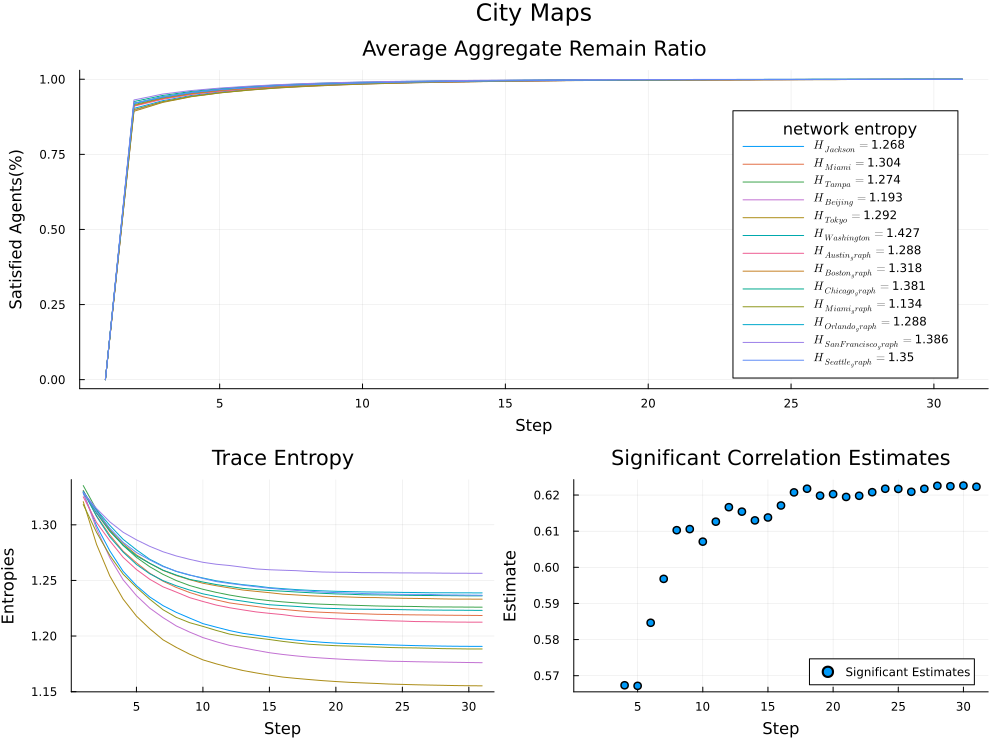

In [63]:
p1 = Plots.plot(city_map_remain, xlabel = "Step",ylabel = "Satisfied Agents(%)",legend=true,labels = HGstr, 
    legendtitle="network entropy",
    title="Average Aggregate Remain Ratio",  left_margin = 4Measures.mm , bottom_margin = 3Measures.mm )

p2 = Plots.plot(city_map_gb_H, xlabel = "Step",ylabel = "Entropies", legend=false,
    title="Trace Entropy", size=(900, 700), left_margin = 2Measures.mm, bottom_margin = 3Measures.mm )

p3 = Plots.scatter(x_values, significant_estimates, label="Significant Estimates",
        xlabel="Step", ylabel="Estimate", title="Significant Correlation Estimates",
        legend=:bottomright)

p = Plots.plot(p1,p2,p3, plot_title="City Maps", size=(1000,750), layout=@layout([A{0.6h}; [B C]]) )

savefig("./plots/Fig$(PLOT_COUNTER)_remainCities.pdf")
Update_Plot_Counter()
display(p)